# Brain Tumor Classification

In [83]:
# loading necessary libraries
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix



import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchmetrics import Accuracy, ConfusionMatrix
import pytorch_lightning as pl
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet50, ResNet50_Weights



from sklearn.model_selection import train_test_split

In [41]:
# setting path to the yes folder and collecting all the .jpeg and .jpg files in a sorted list
imgdir_path_yes = pathlib.Path("brain_tumor_dataset/yes")
file_list_yes = sorted([str(path) for path in imgdir_path_yes.glob('*.jpeg')] +
                       [str(path) for path in imgdir_path_yes.glob('*.jpg')] )
print(file_list_yes[:10])

['brain_tumor_dataset\\yes\\Y1.jpg', 'brain_tumor_dataset\\yes\\Y10.jpg', 'brain_tumor_dataset\\yes\\Y100.JPG', 'brain_tumor_dataset\\yes\\Y101.jpg', 'brain_tumor_dataset\\yes\\Y102.jpg', 'brain_tumor_dataset\\yes\\Y103.jpg', 'brain_tumor_dataset\\yes\\Y104.jpg', 'brain_tumor_dataset\\yes\\Y105.jpg', 'brain_tumor_dataset\\yes\\Y106.jpg', 'brain_tumor_dataset\\yes\\Y107.jpg']


In [42]:
# setting path to the no folder and collecting all the .jpeg and .jpg files in a sorted list
img_path_no = pathlib.Path("brain_tumor_dataset/no")
file_list_no = sorted([str(path) for path in img_path_no.glob('*.jpeg')] +
                      [str(path) for path in img_path_no.glob('*.jpg')])
print(file_list_no[:10])

['brain_tumor_dataset\\no\\1 no.jpeg', 'brain_tumor_dataset\\no\\10 no.jpg', 'brain_tumor_dataset\\no\\11 no.jpg', 'brain_tumor_dataset\\no\\12 no.jpg', 'brain_tumor_dataset\\no\\13 no.jpg', 'brain_tumor_dataset\\no\\14 no.jpg', 'brain_tumor_dataset\\no\\15 no.jpg', 'brain_tumor_dataset\\no\\17 no.jpg', 'brain_tumor_dataset\\no\\18 no.jpg', 'brain_tumor_dataset\\no\\19 no.jpg']


In [43]:
# combining a few files for inspection
file_list_both = file_list_yes[:3] + file_list_no[:3]
file_list_both

['brain_tumor_dataset\\yes\\Y1.jpg',
 'brain_tumor_dataset\\yes\\Y10.jpg',
 'brain_tumor_dataset\\yes\\Y100.JPG',
 'brain_tumor_dataset\\no\\1 no.jpeg',
 'brain_tumor_dataset\\no\\10 no.jpg',
 'brain_tumor_dataset\\no\\11 no.jpg']

Image shape: (218, 180, 3)
Image shape: (360, 319)
Image shape: (348, 287, 3)
Image shape: (630, 630)
Image shape: (201, 173, 3)
Image shape: (168, 300, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

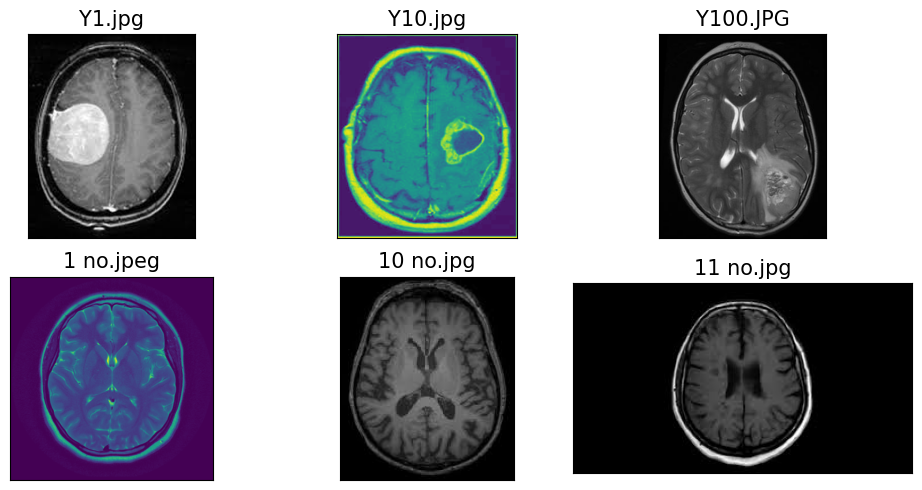

In [44]:
# plotting a few pictures for inspection
fig = plt.figure(figsize=(10,5))
for i, file in enumerate(file_list_both):
    img = Image.open(file)
    print('Image shape:', np.array(img).shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file), size=15)
plt.tight_layout()
plt.show

We can observe that the images vary in both dimensions and number of channels

In [45]:
# creating a combined list of both and a list for labels
file_list_both = file_list_yes + file_list_no
labels = [1 if 'yes' in os.path.dirname(file) else 0 for file in file_list_both]

In [46]:
# inspecting files with corresponding labels
for file, label in zip(file_list_both, labels):
    print(file, label)

brain_tumor_dataset\yes\Y1.jpg 1
brain_tumor_dataset\yes\Y10.jpg 1
brain_tumor_dataset\yes\Y100.JPG 1
brain_tumor_dataset\yes\Y101.jpg 1
brain_tumor_dataset\yes\Y102.jpg 1
brain_tumor_dataset\yes\Y103.jpg 1
brain_tumor_dataset\yes\Y104.jpg 1
brain_tumor_dataset\yes\Y105.jpg 1
brain_tumor_dataset\yes\Y106.jpg 1
brain_tumor_dataset\yes\Y107.jpg 1
brain_tumor_dataset\yes\Y108.jpg 1
brain_tumor_dataset\yes\Y109.JPG 1
brain_tumor_dataset\yes\Y11.jpg 1
brain_tumor_dataset\yes\Y111.JPG 1
brain_tumor_dataset\yes\Y112.JPG 1
brain_tumor_dataset\yes\Y113.JPG 1
brain_tumor_dataset\yes\Y114.JPG 1
brain_tumor_dataset\yes\Y115.JPG 1
brain_tumor_dataset\yes\Y116.JPG 1
brain_tumor_dataset\yes\Y117.JPG 1
brain_tumor_dataset\yes\Y12.jpg 1
brain_tumor_dataset\yes\Y120.JPG 1
brain_tumor_dataset\yes\Y13.jpg 1
brain_tumor_dataset\yes\Y14.jpg 1
brain_tumor_dataset\yes\Y146.JPG 1
brain_tumor_dataset\yes\Y147.JPG 1
brain_tumor_dataset\yes\Y148.JPG 1
brain_tumor_dataset\yes\Y15.jpg 1
brain_tumor_dataset\yes\Y153

In [47]:
# counting the number of each class
pd.Series(labels).value_counts()

1    154
0     97
Name: count, dtype: int64

In [48]:
# inspecting the labels have the same number of observations as the original files
len(file_list_yes), len(file_list_no)

(154, 97)

In [49]:
# Create a Custom Torch Dataset 
class CustomImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform
        

    def __getitem__(self, index):
        # Load the image at the given index
        img = Image.open(self.file_list[index])
        # Apply transformations
        if self.transform is not None:
            img = self.transform(img)
        label = self.labels[index]
        return img, label

    def __len__(self):
        return len(self.labels)



In [50]:
# Lightning DataModule for brain tumor data
class TumorDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        
        # Transformations applied on training images
        self.train_transform = transforms.Compose([
            transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
            transforms.RandomCrop(224),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Transformations for validation/test images
        self.test_transform = transforms.Compose([
            transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),
            transforms.CenterCrop(224),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def prepare_data(self):
        # Load and list all images from the 'yes' and 'no' directories
        imgdir_path_yes = pathlib.Path("brain_tumor_dataset/yes")
        file_list_yes = sorted([str(path) for path in imgdir_path_yes.glob('*.jpeg')] +
                       [str(path) for path in imgdir_path_yes.glob('*.jpg')] )
        img_path_no = pathlib.Path("brain_tumor_dataset/no")
        file_list_no = sorted([str(path) for path in img_path_no.glob('*.jpeg')] +
                      [str(path) for path in img_path_no.glob('*.jpg')])
        
        # Combine image lists and create corresponding labels
        self.file_list_both = file_list_yes + file_list_no
        self.labels = [1 if 'yes' in os.path.dirname(file) else 0 for file in self.file_list_both]

    def setup(self, stage=None):
        # Split dataset into train/val/test sets 
        X_train, X_temp, y_train, y_temp = train_test_split(self.file_list_both, self.labels, test_size=0.3, stratify=self.labels, random_state=1)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=1)


        # Create PyTorch Dataset objects for each split
        self.train = CustomImageDataset(X_train, y_train, transform=self.train_transform)
        self.val = CustomImageDataset(X_val, y_val, transform=self.test_transform)
        self.test = CustomImageDataset(X_test, y_test, transform=self.test_transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=8, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=8)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=8)

In [51]:
# setup the Lightning DataModule
tumor_data = TumorDataModule()
tumor_data.prepare_data()
tumor_data.setup()

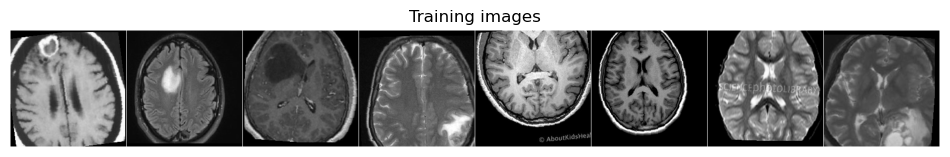

In [82]:
# inspecting the images of the training dataloader
for images, labels in tumor_data.train_dataloader():  
    break

plt.figure(figsize=(12, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:8], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))

plt.show()

In [61]:
# checking the size
images[0].shape

torch.Size([3, 224, 224])

In [53]:
# Creating a CNN model using sequential 
class PyTorchCNN(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d( in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(p=0.5),


            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten()

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        logits = self.fc_layers(x)
        return logits

In [54]:
# Creating a wrapper LightningModel for the PyTorch model to handle training and testing steps
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = Accuracy(task = "binary")
        self.val_acc = Accuracy(task = "binary")
        self.test_acc = Accuracy(task = "binary")

    def forward(self, x):
        return self.model(x)


    def _shared_step(self, batch):
        images, true_labels = batch
        true_labels = true_labels.unsqueeze(1)
        logits = self(images)

        loss_fn = nn.BCEWithLogitsLoss()
        loss = loss_fn(logits, true_labels.float())
        predicted_labels = (torch.sigmoid(logits) > 0.5).float()
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer 
        

In [55]:
# Inspecting the label count distribution in all three dataloaders
test_loader = tumor_data.test_dataloader()
train_loader = tumor_data.train_dataloader()
val_loader = tumor_data.val_dataloader()


train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())
    
print("\nTraining label distribution:")
print(sorted(train_counter.items()))

    
val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())
    
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 68), (1, 107)]

Validation label distribution:
[(0, 15), (1, 23)]

Test label distribution:
[(0, 14), (1, 24)]


In [56]:
# Creating a dummy model which always chooses one class as a baseline to beat
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.63 (63.16%)


In [57]:
# Set random seed for reproducibility
pl.seed_everything(123)


pytorch_model = PyTorchCNN(num_classes=1)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', deterministic=True, 
              logger=CSVLogger(save_dir='logs/', name="Tumor_model"))

# Initialize the Tuner for automatic hyperparameter search
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(lightning_model, datamodule=tumor_data)

Seed set to 123
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\pc\anaconda3\envs\new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\pc\anaconda3\envs\new\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
C:\Users\pc\anaconda3\envs\n

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at C:\Users\pc\Data Science\Python\Projects\Brain Tumor Classification\.lr_find_143e159a-73e0-4d83-9d59-50cdd2556cea.ckpt
Restored all states from the checkpoint at C:\Users\pc\Data Science\Python\Projects\Brain Tumor Classification\.lr_find_143e159a-73e0-4d83-9d59-50cdd2556cea.ckpt
Learning rate set to 1.7378008287493761e-06


_TunerExitException: 

In [58]:
%%capture --no-display

pl.seed_everything(123)

# Initialize the CNN model 
pytorch_model = PyTorchCNN(num_classes=1)

# Initialize LightningModule with a adjusted learning rate
lightning_model = LightningModel(
    model=pytorch_model, 
    learning_rate=0.000383078054770101
)

# callback list to save the best model according to validation accuracy
callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor='val_acc')]

# Trainer
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=callbacks,
    accelerator='gpu',
    deterministic=True,
    logger=CSVLogger(save_dir="logs/", name="my-model")
)

# Fit the model
trainer.fit(model=lightning_model, datamodule=tumor_data)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | PyTorchCNN     | 422 K  | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.690     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


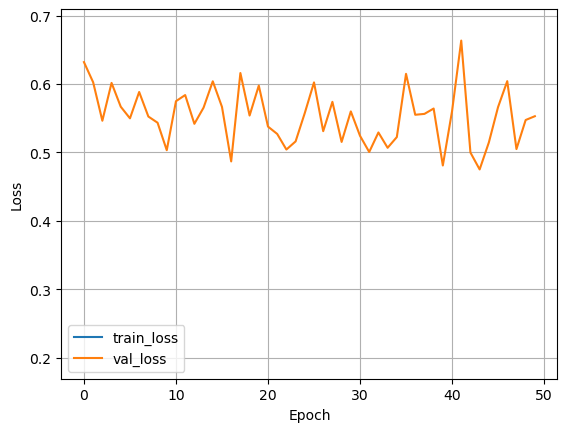

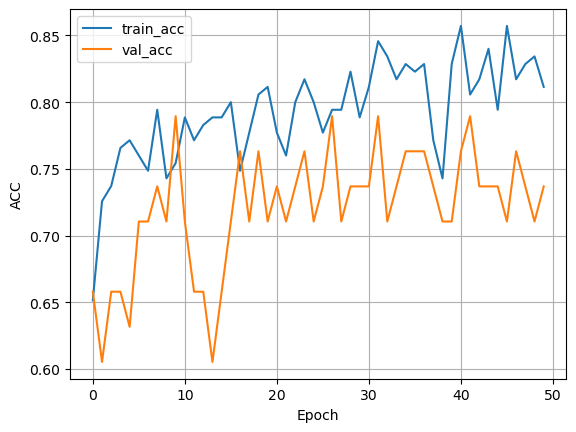

In [59]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

In [60]:
# using the best model on the test dataset
trainer.test(model=lightning_model, datamodule=tumor_data, ckpt_path="best")

Restoring states from the checkpoint path at logs/my-model\version_1\checkpoints\epoch=9-step=220.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/my-model\version_1\checkpoints\epoch=9-step=220.ckpt
C:\Users\pc\anaconda3\envs\new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7368420958518982     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7368420958518982}]

The model’s accuracy is relatively low compared to the dummy baseline, which achieved around 60%. This is mainly due to the limited number of training images, so applying transfer learning can help overcome the challenges posed by the small dataset.

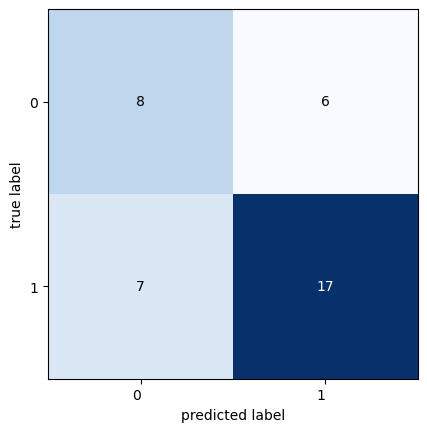

In [62]:
cmat = ConfusionMatrix(task="binary")

for x, y in tumor_data.test_dataloader():

    with torch.inference_mode():
        pred = lightning_model(x)
        pred_labels = (torch.sigmoid(pred) > 0.5).long()
        cmat.update(pred_labels, y.unsqueeze(1))

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks( ha="right", rotation_mode="anchor")
plt.show()

## Transfer Learning

In [63]:
# Load ResNet-50 with pretrained ImageNet weights for transfer learning
pytorch_resnet_model = torch.hub.load('pytorch/vision', 'resnet50', weights ='IMAGENET1K_V1')

Using cache found in C:\Users\pc/.cache\torch\hub\pytorch_vision_main


In [64]:
# inspecting the model in order to adjust the dense head 
pytorch_resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [65]:
# freezing the weights for all convolutional layers
for param in pytorch_resnet_model.parameters():
    param.requires_grad = False

# create a new head layer
pytorch_resnet_model.fc = nn.Linear(2048, 1)

In [81]:
# inspecting the transformations required matches the one already applied
weights = ResNet50_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()
preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [69]:
# inspecting the model after adjusting the fc layer
pytorch_resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
%%capture --no-display

pl.seed_everything(123)



# Initialize LightningModule
lightning_model = LightningModel( model=pytorch_resnet_model, learning_rate=0.1
)

# callback to store best model
callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor='val_acc')]

# Trainer
trainer = pl.Trainer(
    max_epochs=25,
    callbacks=callbacks,
    accelerator='gpu',
    deterministic=True,
    logger=CSVLogger(save_dir="logs/", name="my-model")
)

# Fit the model
trainer.fit(model=lightning_model, datamodule=tumor_data)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | ResNet         | 23.5 M | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
2.0 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


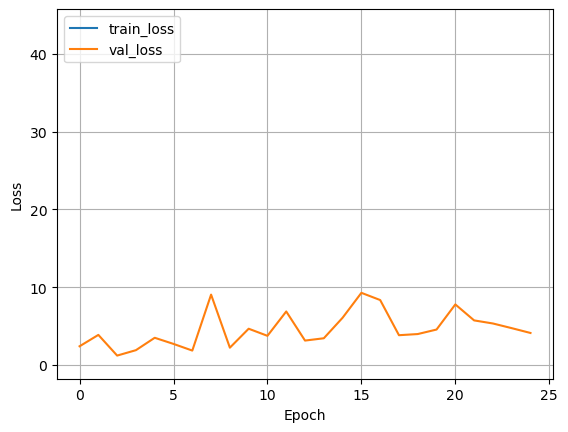

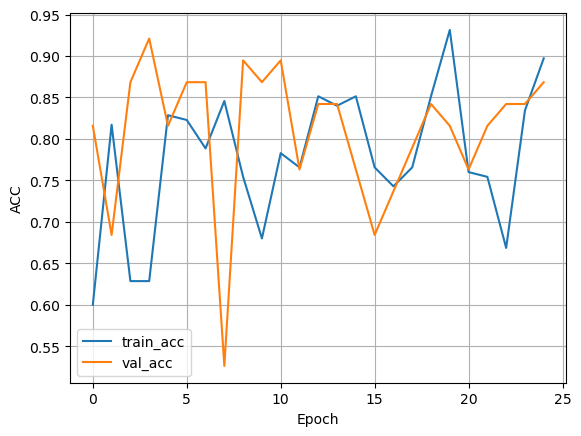

In [72]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

The model shows a significant improvement over our previous one.  
To enhance performance further, Stage 2 will involve fine-tuning the last convolutional layers of the ResNet50 model.

In [75]:
# Unfreeze the parameters of the last ResNet50 convolutional block (layer4) so they can be updated during fine-tuning
for param in pytorch_resnet_model.layer4.parameters():
    param.requires_grad = True

In [76]:
%%capture --no-display

pl.seed_everything(123)



# Initialize LightningModule with a lower learning rate for fine-tuning
lightning_model = LightningModel( model=pytorch_resnet_model, learning_rate=0.001
)

# save the best model based on validation accuracy
callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor='val_acc')]

# Trainer
trainer = pl.Trainer(
    max_epochs=10, # fewer epochs for fine-tuning
    callbacks=callbacks,
    accelerator='gpu',
    deterministic=True,
    logger=CSVLogger(save_dir="logs/", name="my-model")
)

# Fit the model
trainer.fit(model=lightning_model, datamodule=tumor_data)

Seed set to 123
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | ResNet         | 23.5 M | train
1 | train_acc | BinaryAccuracy | 0      | train
2 | val_acc   | BinaryAccuracy | 0      | train
3 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


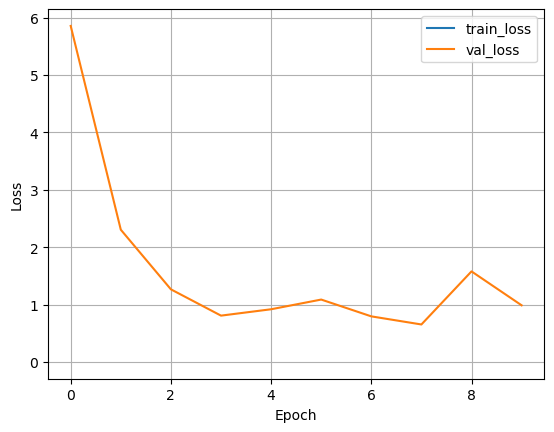

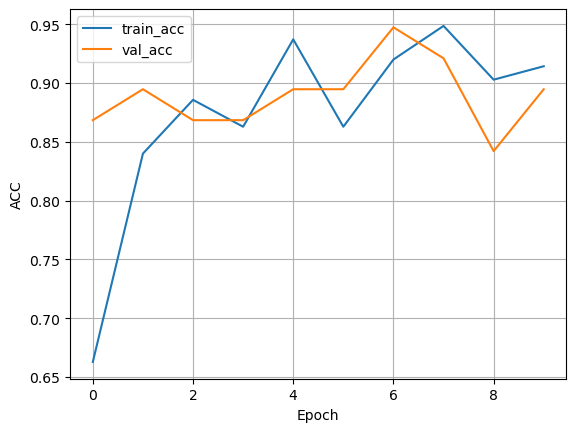

In [77]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

In [78]:
trainer.test(model=lightning_model, datamodule=tumor_data, ckpt_path="best")

Restoring states from the checkpoint path at logs/my-model\version_3\checkpoints\epoch=6-step=154.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/my-model\version_3\checkpoints\epoch=6-step=154.ckpt
C:\Users\pc\anaconda3\envs\new\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9210526347160339     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9210526347160339}]

The model's performance has improved further, achieving an accuracy of 92% on the test set.